# The detailed analysis of the results

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import plotly.express as px

from core import *
from config import image_stats_file, adjusted_scores_file, figures_dir, latex_dir, xls_file

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 10000)

figsize_rect= (6, 3)
figsize_square= (5, 4)

In [2]:
data= pd.read_csv(adjusted_scores_file)
image_data= pd.read_csv(image_stats_file)

methods= pd.read_excel(xls_file, engine='openpyxl')
#methods= methods.iloc[:methods[methods['key'].isnull()].index[0]]
n_aggregated_figures= methods[['key', 'acc']].groupby('key').agg({'acc': 'count'}).reset_index(drop=False).rename({'acc': 'n_aggregated'}, axis='columns')

In [3]:
data= pd.merge(data, n_aggregated_figures, on='key')

## Summary of data

In [4]:
data.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec', 'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc', 'second_human_sens', 'second_human_spec', 'image_level', 'short_description', 'operating_principles', 'citations', 'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking', 'image_level_consistency_with_fov', 'image_level_consistency_without_fov', 'n_image_level', 'category', 'n_aggregated_scores', 'consistency_with_fov_mor', 'consistency_without_fov_mor', 'consistency_with_fov_rom', 'consistency_without_fov_rom', 'consistency_with_fov', 'consistency_without_fov', 'category_agg', 'category_final', 'aggregated_adj_acc', 'aggregated_adj_acc_delta', 'aggregated_adj_spec', 'aggregated_adj_spec_delta', 'aggregated_adj_sens', 'aggregated_adj_sens_delta', 'image_level_adj_acc', 'image_level_adj_acc_delta', 'image_level_adj_spec', 'image_level_adj_spec_delta', 'image_level_adj_sens', 'image_level_adj_sens_delta', 'acc_final', 'spec_f

In [5]:
len(data)

100

In [6]:
all= data[['key', 'acc', 'n_image_level', 'n_aggregated', 'second_human_acc', 'explicit_fov_usage', 'digits', 'citations']].sort_values('acc', ascending=False).reset_index(drop=True).reset_index()

In [7]:
all

,index,key,acc,n_image_level,n_aggregated,second_human_acc,explicit_fov_usage,digits,citations
0,0,jebaseeli2019,0.9898,NaN,1,NaN,yes,4.0,6.0
1,1,hassan2018,0.9793,20.0,1,NaN,no mention,4.0,24.0
2,2,wang2015,0.9767,20.0,9,0.9464,yes,4.0,274.0
3,3,villalobos-castaldi2010,0.9759,NaN,1,0.9473,no,4.0,70.0
4,4,memari2017,0.9722,NaN,3,0.9464,no mention,4.0,23.0
5,5,park2020,0.9706,NaN,1,NaN,no mention,4.0,2.0
6,6,jiang2019,0.9706,NaN,9,0.9637,no mention,4.0,9.0
7,7,atli2020,0.9689,NaN,2,0.9637,no mention,4.0,3.0
8,8,moghimirad2012,0.9659,4.0,1,0.9473,yes,4.0,44.0
9,9,pan2019,0.9650,NaN,1,NaN,no mention,4.0,12.0


In [8]:
def rounding(score, digits):
    return ('%.4f' % score)[1:(2 + int(digits))]

In [9]:
latex= all.copy()
latex.loc[latex['n_image_level'].isna(), 'n_image_level']= ''
latex.loc[~(latex['n_image_level'] == ''), 'n_image_level']= latex.loc[~(latex['n_image_level'] == ''), 'n_image_level'].apply(int).apply(str)
latex.loc[latex['explicit_fov_usage'] == 'no mention', 'explicit_fov_usage']= ''
latex['key']= latex['key'].apply(lambda x: x[0:1].upper() + x[1:])
latex['key']= latex['key'].apply(lambda x: ' \cite{' + x.lower() + '}')
latex['acc']= latex[['acc', 'digits']].apply(lambda x: rounding(x.acc, x.digits), axis=1)
cond= latex['second_human_acc'].isna()
latex.loc[~cond, 'second_human_acc']= latex.loc[~cond, ['second_human_acc', 'digits']].apply(lambda x: rounding(x['second_human_acc'], x['digits']), axis=1)
latex.loc[cond, 'second_human_acc']= ''
latex['second_human_acc']= latex['second_human_acc'].apply(str)
latex.loc[latex['explicit_fov_usage'] == 'yes', 'explicit_fov_usage']= 'F'
latex.loc[latex['explicit_fov_usage'] == 'no', 'explicit_fov_usage']= 'a'
latex['explicit_fov_usage']= latex['explicit_fov_usage'].apply(lambda x: x if isinstance(x, str) or x is None else '?')
latex['citations']= latex['citations'].apply(int).apply(str)
latex['index']= (latex['index']+1).apply(str)
latex['digits']= latex['digits'].apply(int).apply(str)
latex= latex[['index', 'key', 'acc', 'n_image_level', 'n_aggregated', 'second_human_acc', 'explicit_fov_usage', 'digits', 'citations']]
latex.columns= ['\rotatebox{90}{Rank}', 'Key', '$\overline{acc}$', '\rotatebox{90}{Num. image level}', '\rotatebox{90}{Num. aggregated}', '\rotatebox{90}{Annotator \#2 acc.}', '\rotatebox{90}{Region of eval.}', '\rotatebox{90}{Decimal places}', '\rotatebox{90}{Citations}']
latex= break_table(latex, columns=2, index=False).fillna('')
latex_str= set_column_spaces(latex.to_latex(escape=False, index=False), n_cols=9, col_space=2, big_col_space=6)
with open(os.path.join(latex_dir, "tab1.tex"), "w") as text_file:
    text_file.write(latex_str)

In [10]:
data.groupby('category_final').agg({'key': 'count'})

,key
category_final,
FoV,36
no FoV,28
outlier,36


## Improved ranking

In [11]:
data= data.sort_values('acc', ascending=False).reset_index(drop=True).reset_index(drop=False)
data= data.rename({'index': 'original_rank'}, axis='columns')

In [12]:
categories_labels= {'deep learning': 'deep learning',
'filtering, thresholding, morphology, region growing': 'classical',
'feature extraction, classification': 'supervised',
'other': 'other'}

In [13]:
data.columns

Index(['original_rank', 'key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec', 'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc', 'second_human_sens', 'second_human_spec', 'image_level', 'short_description', 'operating_principles', 'citations', 'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking', 'image_level_consistency_with_fov', 'image_level_consistency_without_fov', 'n_image_level', 'category', 'n_aggregated_scores', 'consistency_with_fov_mor', 'consistency_without_fov_mor', 'consistency_with_fov_rom', 'consistency_without_fov_rom', 'consistency_with_fov', 'consistency_without_fov', 'category_agg', 'category_final', 'aggregated_adj_acc', 'aggregated_adj_acc_delta', 'aggregated_adj_spec', 'aggregated_adj_spec_delta', 'aggregated_adj_sens', 'aggregated_adj_sens_delta', 'image_level_adj_acc', 'image_level_adj_acc_delta', 'image_level_adj_spec', 'image_level_adj_spec_delta', 'image_level_adj_sens', 'image_level_adj_sens_delta', 'ac

In [14]:
adjusted= data[data['acc_final'].notnull()].copy()

In [15]:
adjusted= adjusted.sort_values('acc_final', ascending=False).reset_index(drop=True).reset_index(drop=False)
adjusted.loc[adjusted['category_final'] == 'no FoV', 'category_final']= 'all pixels'
adjusted['acc_final']= adjusted['acc_final'].apply(lambda x: ('%.4f' % x)[1:])
adjusted['acc']= adjusted['acc'].apply(lambda x: ('%.4f' % x)[1:])
adjusted= adjusted.rename({'index': 'rank'}, axis='columns')
adjusted['rank']= adjusted['rank'] + 1
adjusted['original_rank']= adjusted['original_rank'] + 1
adjusted['rank_diff']= adjusted['original_rank'] - adjusted['rank']
adjusted['rank']= adjusted['rank'].map(str)
adjusted['original_rank']= adjusted['original_rank'].map(str)
adjusted['rank_diff']= adjusted['rank_diff'].map(str)
adjusted= adjusted[['key', 'rank', 'original_rank', 'rank_diff', 'acc_final', 'acc', 'category_final', 'operating_principles']]
adjusted['operating_principles']= adjusted['operating_principles'].apply(lambda x: categories_labels[x])
adjusted['key']= adjusted['key'].apply(lambda x: x[0:1].upper() + x[1:])
adjusted['key']= adjusted['key'].apply(lambda x: ' \cite{' + x.lower() + '}')
adjusted.columns=['Key', '\rotatebox{90}{Rank}', '\rotatebox{90}{Original rank}', '\rotatebox{90}{Rank diff.}', '\rotatebox{90}{Adjusted acc.}', '\rotatebox{90}{Published acc.}', 'Category', 'Operation']
adjusted

,Key,\rotatebox{90}{Rank},\rotatebox{90}{Original rank},\rotatebox{90}{Rank diff.},\rotatebox{90}{Adjusted acc.},\rotatebox{90}{Published acc.},Category,Operation
0,\cite{wu2020},1,30,29,.9582,.9582,FoV,deep learning
1,\cite{park2020},2,6,4,.9578,.9706,all pixels,deep learning
2,\cite{jiang2019},3,7,4,.9578,.9706,all pixels,deep learning
3,\cite{noh2019},4,34,30,.9569,.9569,FoV,deep learning
4,\cite{yan2018},5,39,34,.9542,.9542,FoV,deep learning
5,\cite{liskowski2016},6,44,38,.9535,.9535,FoV,deep learning
6,\cite{ngo2017},7,47,40,.9533,.9533,FoV,deep learning
7,\cite{dasgupta2017},8,46,38,.9533,.9533,FoV,deep learning
8,\cite{li2016},9,52,43,.9527,.9527,FoV,deep learning
9,\cite{mo2017},10,55,45,.9521,.9521,FoV,deep learning


In [16]:
#latex= break_table(adjusted, columns=2, index=False).fillna('')
latex_str= set_column_spaces(adjusted.to_latex(escape=False, index=False), n_cols=8, col_space=3, big_col_space=6)
#latex_str= latex.to_latex(escape=False, index=False)
with open(os.path.join(latex_dir, "tab4.tex"), "w") as text_file:
    text_file.write(latex_str)

## Consistency of image level and aggregated analysis

In [17]:
# How consistent the image level and aggregated analysis is?

tmp= data[data['category'].notnull()][['key', 'category', 'category_agg', 'category_final']]
tmp['agreement']= tmp['category'] == tmp['category_agg']
print(np.sum(tmp['agreement'])/len(tmp))

0.5555555555555556


In [18]:
tmp.groupby(['agreement', 'category', 'category_agg']).agg({'key': 'count'})

key
agreement category category_agg     
False     outlier  FoV             8
                   ambiguous       1
                   no FoV          7
True      FoV      FoV             6
          no FoV   no FoV         10
          outlier  outlier         4

In [19]:
tmp[(tmp['category'] == 'outlier') & (tmp['category_agg'] == 'ambiguous')]

,key,category,category_agg,category_final,agreement
1,hassan2018,outlier,ambiguous,outlier,False


## Consistency of explicit FoV usage

In [20]:
data.groupby(['explicit_fov_usage', 'category_final']).agg({'acc': 'count'})

acc
explicit_fov_usage category_final     
no                 no FoV            3
                   outlier           3
no mention         FoV              24
                   no FoV           24
                   outlier          23
yes                FoV              12
                   no FoV            1
                   outlier          10

## Trends

In [21]:
# What was the fraction of categories over the years?

tmp= data[['year', 'category_final', 'key']]
tmp= tmp.groupby(['year', 'category_final']).agg({'key': 'count'})
tmp= tmp.reset_index(drop=False).pivot(index='year', columns='category_final', values='key').fillna(0).rolling(window=4).mean()
tmp= tmp.dropna()
print(tmp.dropna)

<bound method DataFrame.dropna of category_final   FoV  no FoV  outlier
year                                 
2008.0          0.50    0.00     0.50
2010.0          0.50    0.25     0.75
2011.0          1.00    0.25     1.00
2012.0          1.00    0.25     1.75
2013.0          1.00    1.00     1.75
2014.0          1.75    1.00     1.75
2015.0          2.00    1.75     3.00
2016.0          3.25    3.50     2.50
2017.0          5.25    4.00     3.75
2018.0          5.00    4.00     4.50
2019.0          4.25    4.00     4.00
2020.0          4.25    3.25     4.50>


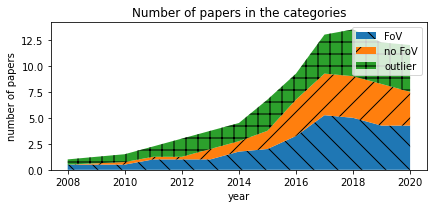

In [22]:
fig, ax= plt.subplots(figsize=figsize_rect)
stacks= ax.stackplot(tmp.index, [tmp['FoV'], tmp['no FoV'], tmp['outlier']], labels=['FoV', 'no FoV', 'outlier'])
stacks[0].set_hatch('\\')
stacks[1].set_hatch('/')
stacks[2].set_hatch('+')
plt.xlabel('year')
plt.ylabel('number of papers')
plt.title('Number of papers in the categories')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'paper_categories.pdf'))
plt.show()

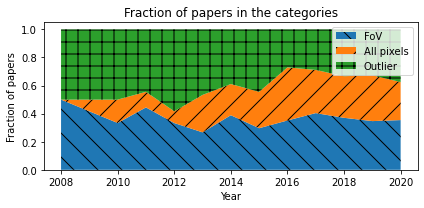

In [23]:
tmp= tmp.div(tmp.sum(axis=1), axis=0)
fig, ax= plt.subplots(figsize=figsize_rect)
stacks= ax.stackplot(tmp.index, [tmp['FoV'], tmp['no FoV'], tmp['outlier']], labels=['FoV', 'All pixels', 'Outlier'])
stacks[0].set_hatch('\\')
stacks[1].set_hatch('/')
stacks[2].set_hatch('+')
plt.xlabel('Year')
plt.ylabel('Fraction of papers')
plt.title('Fraction of papers in the categories')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'paper_category_fractions.pdf'))
plt.show()

/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCop

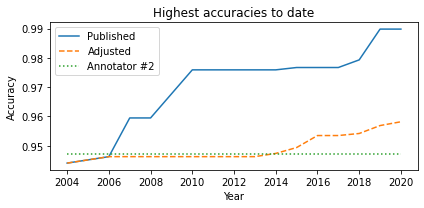

In [24]:
# how did the accuracies change over time?

tmp= data[['year', 'acc', 'acc_final', 'category_final']]
tmp.loc[tmp['category_final'] == 'outlier', 'acc_corrected']= None
tmp.loc[tmp['category_final'] == 'FoV', 'acc_corrected']= tmp.loc[tmp['category_final'] == 'FoV', 'acc']
tmp= tmp.groupby('year').agg({'acc': 'max', 'acc_corrected': 'max'})
tmp= tmp.fillna(method='ffill').cummax()

plt.figure(figsize=figsize_rect)
plt.plot(tmp.index, tmp['acc'], label='Published', ls='solid')
plt.plot(tmp.index, tmp['acc_corrected'], label='Adjusted', ls='dashed')
plt.plot(tmp.index, np.repeat(0.9473, len(tmp)), label='Annotator #2', ls=':')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.title('Highest accuracies to date')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'highest_accuracy.pdf'))
plt.show()

## Consistency of rankings in papers

In [25]:
# checking the consistency of the invalid ranking declarations:
# 1) all papers referred as the cause of invalid ranking are included in the study
# 2) all papers with the ones referred as the causes of invalid rankings fall in at least 2 categories
#
# if the test passes, this cell has no output

# are there papers referred in the cause of invalid ranking fields which are not in the set of papers?
invalid_ranking_keys= []

for i, row in data.iterrows():
    if row['cause_of_invalid_ranking'] is None or len(str(row['cause_of_invalid_ranking'])) < 4:
        continue
    keys= [k for k in re.findall(r'\s|,|[^,\s]+', str(row['cause_of_invalid_ranking'])) if (k[-4:] >= '2004' and k[-4:] <= '2021') or (k[-5:-1] >= '2004' and k[-5:-1] <= '2021')]
    invalid_ranking_keys.extend(keys)
invalid_ranking_keys= np.unique(invalid_ranking_keys)
for k in invalid_ranking_keys:
    if len(data[data['key'] == k]) == 0:
        print('not found: %s' % k)

# are the referred causes valid given the category_final assigments?

for i, row in data.iterrows():
    if row['cause_of_invalid_ranking'] is None or len(str(row['cause_of_invalid_ranking'])) < 4:
        continue
    keys= [k for k in re.findall(r'\s|,|[^,\s]+', str(row['cause_of_invalid_ranking'])) if (k[-4:] >= '2004' and k[-4:] <= '2021') or (k[-5:-1] >= '2004' and k[-5:-1] <= '2021') or k.startswith('human')]
    categories= [data[data['key'] == k]['category_final'].values[0] for k in keys if not k.startswith('human')]
    categories.append(row['category_final'])
    if 'human_fov' in keys:
        categories.append('FoV')
    elif 'human_nofov' in keys:
        categories.append('no FoV')
    categories= np.unique(categories)
    if row['invalid_ranking'] == 'yes':
        if len(categories) < 2:
            print('inproper entry: %s, %s, %s, %s' % (row['key'], row['invalid_ranking'], str(keys), str(categories)))
    else:
        if len(categories) >= 2:
            print('inproper entry: %s, %s, %s, %s' % (row['key'], row['invalid_ranking'], str(keys), str(categories)))

In [26]:
# How consistent the rankings in papers are?

np.sum(data['invalid_ranking'] == 'yes')

91

In [27]:
def find_category(x):
    if x == 'human':
        return 'FoV'
    tmp= data[data['key'] == x]
    if len(tmp) == 0:
        print('not found: %s' % x)
        return ''
    return tmp['category_final'].values[0]

def find_accuracy(x):
    if x == 'human':
        return 0.9473
    tmp= data[data['key'] == x]
    if len(tmp) == 0:
        print('not found: %s' % x)
        return None
    return tmp['acc'].values[0]

In [28]:
tmp= data
tmp['highest_ranked_category']= data['highest_ranked'].apply(find_category)
tmp['highest_ranked_accuracy']= data['highest_ranked'].apply(find_accuracy)

not found: liang2019
not found: nan
not found: -
not found: al-rawi2007
not found: liang2019
not found: nan
not found: -
not found: al-rawi2007


In [29]:
# How many times were 'no FoV' or 'outlier' categories reported as top?

invalid_rankings= tmp[tmp['invalid_ranking'] == 'yes']
print('%d/%d' % (np.sum(invalid_rankings['highest_ranked_category'].isin(['no FoV', 'outlier'])), len(invalid_rankings)))

81/91


In [30]:
# How many times did the authors evaluate under FoV and ranked outliers or evaluations using all pixels as highest?

fov= tmp[tmp['category_final'] == 'FoV']
print('%d/%d' % (np.sum(fov['highest_ranked_category'].isin(['no FoV', 'outlier'])), len(fov)))

21/36


In [31]:
# What is the difference of the highest scores reported by authors
tmp['diff_to_highest_ranked']= tmp['highest_ranked_accuracy'] - tmp['acc']
tmp['diff_to_highest_ranked'].describe()

count    96.000000
mean      0.005924
std       0.008044
min       0.000000
25%       0.000000
50%       0.001200
75%       0.008025
max       0.029800
Name: diff_to_highest_ranked, dtype: float64

In [32]:
tmp[(tmp['category_final'].isin(['no FoV'])) & (np.abs(tmp['second_human_acc'] - 0.9473) < 0.002)][['key', 'second_human_acc']].reset_index(drop=True)

,key,second_human_acc
0,sreejini2015,0.9470
1,samuel2019,0.9470
2,lupascu2016,0.9473
3,lupascu2010,0.9473
4,budai2013,0.9470
5,na2018,0.9470
6,panda2016,0.9470
7,geetharamani2016,0.9470
8,mapayi2015,0.9473
9,nazari2013,0.9470


In [33]:
tmp[(tmp['category_final'].isin(['FoV']))][['key', 'second_human_acc']].reset_index(drop=True)

,key,second_human_acc
0,wu2020,NaN
1,noh2019,0.9472
2,yan2018,0.9472
3,liskowski2016,0.9473
4,dasgupta2017,NaN
5,ngo2017,NaN
6,li2016,0.9472
7,mo2017,NaN
8,zhang2018,0.9472
9,song2017,0.9473


## Improvements in ranking

In [34]:
# How much did the papers improve in ranking after correction

tmp= data[['key', 'year', 'acc', 'acc_final', 'category_final', 'original_rank']].copy()

data_with_corrected_acc= tmp[tmp['acc_final'].notnull()]
data_with_corrected_acc= data_with_corrected_acc.sort_values('acc_final', ascending=False)
data_with_corrected_acc= data_with_corrected_acc.reset_index(drop=True).reset_index(drop=False).rename({'index': 'updated_rank'}, axis='columns')

data_with_corrected_acc['rank_difference']= np.abs(data_with_corrected_acc['original_rank'] - data_with_corrected_acc['updated_rank'])
data_with_corrected_acc['rank_difference_sign']= np.sign(data_with_corrected_acc['original_rank'] - data_with_corrected_acc['updated_rank'])
print('with outliers')
print(data_with_corrected_acc['rank_difference'].describe())
print(data_with_corrected_acc.groupby('rank_difference_sign').agg({'key': 'count'}))

print('without outliers')
data_with_corrected_acc= data_with_corrected_acc.sort_values('acc').reset_index(drop=True).reset_index(drop=False).rename({'index': 'original_rank_without_outliers'}, axis='columns')
data_with_corrected_acc['rank_difference_without_outliers']= np.abs(data_with_corrected_acc['original_rank_without_outliers'] - data_with_corrected_acc['updated_rank'])
data_with_corrected_acc['rank_difference_without_outliers_sign']= np.sign(data_with_corrected_acc['original_rank_without_outliers'] - data_with_corrected_acc['updated_rank'])
print(data_with_corrected_acc['rank_difference_without_outliers'].describe())
print(data_with_corrected_acc.groupby('rank_difference_without_outliers_sign').agg({'key': 'count'}))

with outliers
count    64.000000
mean     32.171875
std      20.299781
min       0.000000
25%      13.750000
50%      38.000000
75%      52.000000
max      55.000000
Name: rank_difference, dtype: float64
                      key
rank_difference_sign     
-1                     23
 0                      1
 1                     40
without outliers
count    64.000000
mean     23.656250
std      15.851712
min       0.000000
25%      10.750000
50%      23.000000
75%      33.500000
max      61.000000
Name: rank_difference_without_outliers, dtype: float64
                                       key
rank_difference_without_outliers_sign     
-1                                      33
 0                                       1
 1                                      30


In [35]:
data_with_corrected_acc[['original_rank', 'updated_rank']].dropna().corr()

,original_rank,updated_rank
original_rank,1.000000,0.187193
updated_rank,0.187193,1.000000


In [36]:
data_with_corrected_acc[data_with_corrected_acc['category_final'] == 'FoV']['acc'].describe()

count    36.000000
mean      0.947522
std       0.004673
min       0.938200
25%       0.944200
50%       0.947150
75%       0.950025
max       0.958200
Name: acc, dtype: float64

In [37]:
data_with_corrected_acc['acc_final'].max()

0.9582

## Performance by category

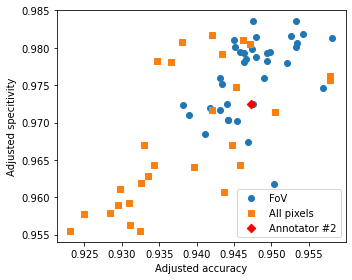

In [38]:
corrected= data[data['acc_final'].notnull()]

plt.figure(figsize=figsize_square)
plt.scatter(corrected['acc_final'][corrected['category_final'] == 'FoV'], corrected['spec_final'][corrected['category_final'] == 'FoV'], label='FoV', marker='o')
plt.scatter(corrected['acc_final'][corrected['category_final'] == 'no FoV'], corrected['spec_final'][corrected['category_final'] == 'no FoV'], label='All pixels', marker='s')
plt.scatter([0.9473], [0.9725], label='Annotator #2', marker='D', color='red')
plt.xlabel('Adjusted accuracy')
plt.ylabel('Adjusted specitivity')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'adjusted_categories.pdf'))
plt.show()

In [39]:
ttest_ind(corrected[corrected['category_final'] == 'FoV']['acc'].values, corrected[corrected['category_final'] == 'no FoV']['acc'].values)

Ttest_indResult(statistic=-7.147881504798354, pvalue=1.1922662455311755e-09)

In [40]:
categories= corrected['operating_principles'].drop_duplicates().values

In [41]:
categories_labels= {'deep learning': 'Deep learning',
'filtering, thresholding, morphology, region growing': 'Classical',
'feature extraction, classification': 'Supervised',
'other': 'Other'}

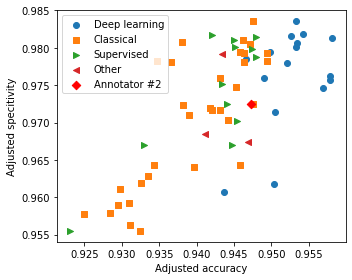

In [42]:
markers= ['o', 's', '>', '<']
plt.figure(figsize=figsize_square)
for i, c in enumerate(categories):
    plt.scatter(corrected['acc_final'][corrected['operating_principles'] == c], corrected['spec_final'][corrected['operating_principles'] == c], label=categories_labels[c], marker=markers[i])
plt.scatter([0.9473], [0.9725], label='Annotator #2', marker='D', color='red')
plt.xlabel('Adjusted accuracy')
plt.ylabel('Adjusted specitivity')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'operating_principles.pdf'))
plt.show()